In [2]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()

In [4]:
adata=sc.read('data/liver_hpc_anno.h5ad',compression='gzip')
adata

AnnData object with n_obs × n_vars = 29370 × 18648
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
import numpy as np
import pandas as pd
bulk=pd.read_csv('data/GSE58827_FPKM.txt.gz',index_col=0,sep='\t',header=1)
#bulk=ov.bulk.Matrix_ID_mapping(bulk,'genesets/pair_GRCm39.tsv')
bulk.head()

,D-2,D-2.1,D-2.2,D0,D0,D0.1,D1,D1.1,D1.2,D3,...,D25.2,D30,D30.1,D30.2,D45,D45.1,D45.2,D60,D60.1,D60.2
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
0610007C21Rik,18.48160,28.29490,24.61790,42.37870,33.34830,41.60700,57.6597,63.41470,64.04740,37.80720,...,51.30120,63.78840,45.19360,54.98550,45.92580,48.11880,56.38370,50.75280,48.55550,54.92510
0610007L01Rik,14.19070,12.70240,11.80150,12.56880,8.31761,9.62451,16.7531,13.15530,13.00190,12.49530,...,7.70820,6.89976,10.68430,11.19820,7.71271,7.78097,6.92665,8.95075,8.89625,7.78528
0610007P08Rik,1.71090,0.83838,0.76108,0.36203,0.50162,0.39988,1.0015,0.64103,0.59142,1.03540,...,0.37039,0.17313,0.62976,0.34409,0.34740,0.27636,0.23581,0.56421,0.71718,0.46741
0610007P14Rik,41.85590,48.17630,45.65490,15.94520,41.84570,49.94160,32.0791,41.87910,30.60340,51.52930,...,49.23110,28.13490,35.72540,44.27430,32.64790,43.05270,31.75820,33.15400,42.72720,49.06030
0610007P22Rik,6.69505,9.71821,8.49785,9.61188,6.70561,7.89604,8.6380,10.05780,11.05510,6.81731,...,6.45745,8.29360,8.04557,7.57137,5.29742,6.44480,7.82238,5.25578,6.53128,7.03206


In [6]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata,
                                    bulk_group=bulk.columns.tolist(),
                                    celltype_key='celltype',)
#bulktb.bulk_preprocess_lazy()
#bulktb.single_preprocess_lazy()

In [7]:
bulktb.vae_configure(cell_target_num=200)

......random select 5000 single cells
......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [12]:
features=bulktb.vae_model.input_data['input_sc_data'].T
labels=bulktb.vae_model.input_data['input_sc_meta']['Cell_type'].astype('str')

# 将类别字符串映射为数字编码
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
labels_encoded = labels.map(label_mapping)

# 转换为 PyTorch 张量
features_tensor = torch.Tensor(features.values)
labels_tensor = torch.LongTensor(labels_encoded.values)  # 使用 LongTensor 存储整数标签


In [13]:
# 创建 DataLoader（如果需要）
# DataLoader 可以帮助你批量加载数据，方便训练
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [14]:
n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
n_classes=len(list(set(labels)))  # 类别数量
img_size=32
channels=1
sample_interval=400
n_features=features.shape[1]

In [15]:
n_classes

18

In [59]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes,n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, n_features),
            #nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        #img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + n_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img, self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [60]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [61]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [62]:
# ----------
#  Training
# ----------
from tqdm import trange,tqdm

n_epochs=5000

bar = tqdm(range(n_epochs))
#for epoch in trange(n_epochs):
d_loss_li=[]
g_loss_li=[]
for epoch in bar:
    for i, (imgs, labels) in enumerate(data_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        break
        
        

        
    bar.set_description(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
        )
    d_loss_li.append(d_loss.item())
    g_loss_li.append(g_loss.item())

[Epoch 4999/5000] [Batch 0/79] [D loss: 0.112926] [G loss: 0.505247]: 100%|██████████| 5000/5000 [00:44<00:00, 112.63it/s]


In [34]:
import pickle
with open('result/cgan_hpc_generator.pkl','wb') as f:
    pickle.dump(generator,f)
    
with open('result/cgan_hpc_discriminator.pkl','wb') as f:
    pickle.dump(discriminator,f)

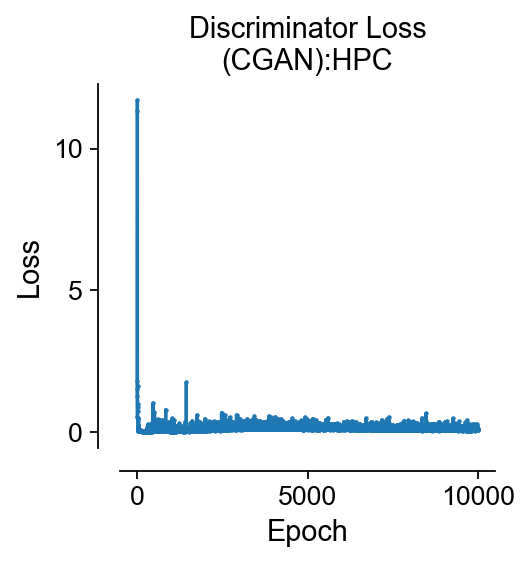

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(d_loss_li)),d_loss_li,s=1)
ax.plot(range(len(d_loss_li)),d_loss_li)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Discriminator Loss\n(CGAN):HPC',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_d_cgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_d_cgan_hpc.pdf',dpi=300,bbox_inches='tight')


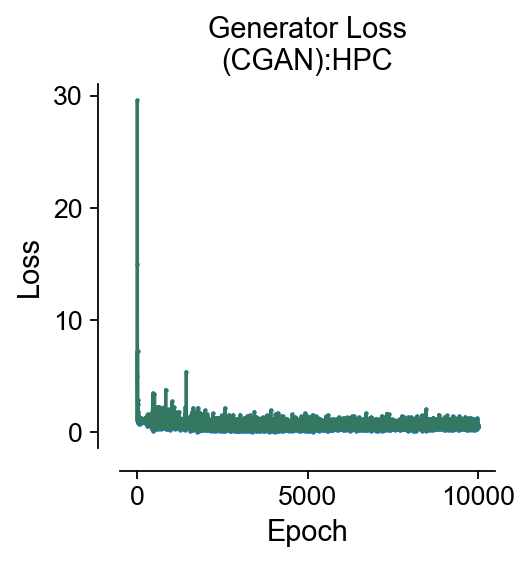

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(g_loss_li)),g_loss_li,s=1)
ax.plot(range(len(g_loss_li)),g_loss_li,color=ov.utils.blue_color[0])

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Generator Loss\n(CGAN):HPC',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_g_cgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_g_cgan_hpc.pdf',dpi=300,bbox_inches='tight')


In [23]:
Variable(FloatTensor(np.random.normal(0, 1, (100, latent_dim)))).shape

torch.Size([100, 100])

In [80]:
n_row=18
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row * 100, latent_dim))))
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(100) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)

In [81]:
gen_imgs.max()

tensor(11.8618, device='cuda:0', grad_fn=<MaxBackward1>)

In [82]:
gen_imgs.min()

tensor(-2.3556, device='cuda:0', grad_fn=<MinBackward1>)

In [83]:


import anndata
test_adata=anndata.AnnData(np.array(gen_imgs.cpu().detach().numpy()))
rev_dict=dict(zip(label_mapping.values(),label_mapping.keys()))
test_adata.obs['celltype_num']=labels.cpu().detach().numpy()
test_adata.obs['celltype']=test_adata.obs['celltype_num'].map(rev_dict)
test_adata


AnnData object with n_obs × n_vars = 1800 × 13849
    obs: 'celltype_num', 'celltype'

In [84]:
test_adata.layers['scaled']=test_adata.X.copy()
ov.pp.pca(test_adata,layer='scaled',n_pcs=50)
test_adata

AnnData object with n_obs × n_vars = 1800 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [85]:
test_adata.obsm["X_mde"] = ov.utils.mde(test_adata.obsm["scaled|original|X_pca"])
test_adata

AnnData object with n_obs × n_vars = 1800 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [86]:
test_adata.var.index=features.columns

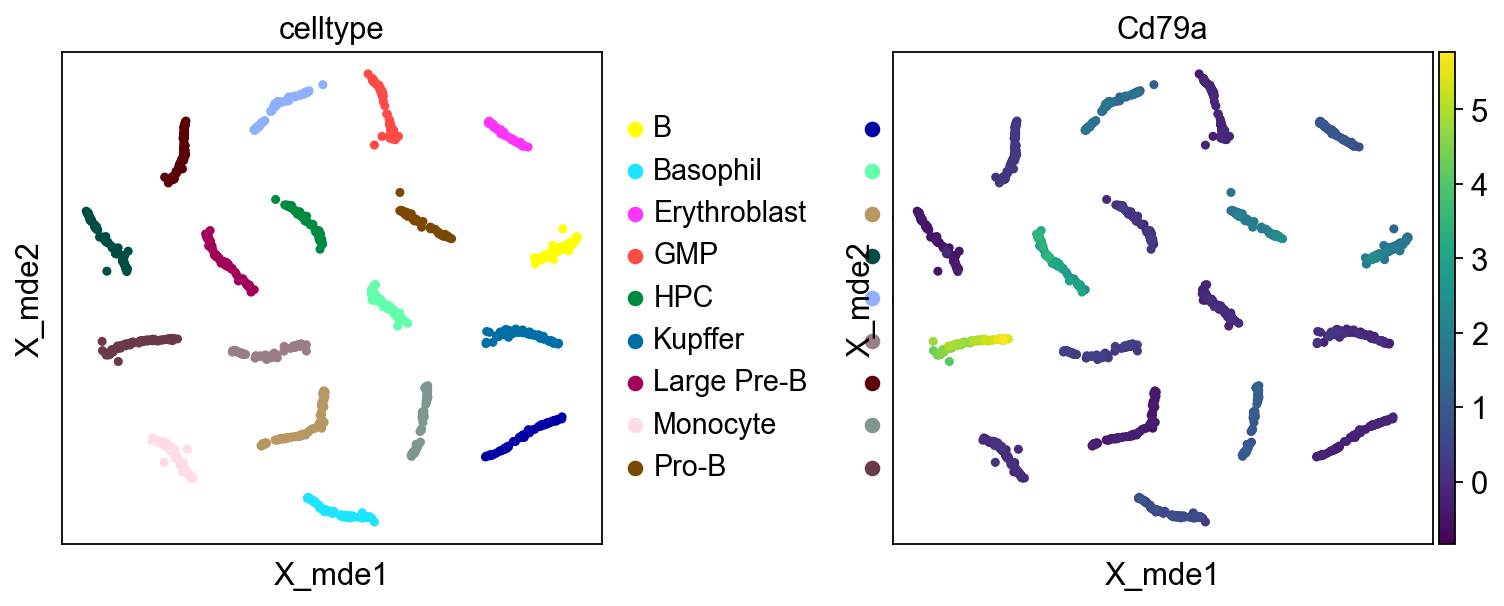

In [87]:
sc.pl.embedding(test_adata,
                basis='X_mde',
           color=['celltype','Cd79a'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

In [73]:
adata.uns['log1p']['base']=10

In [74]:
cor_pd=ov.bulk2single.bulk2single_plot_correlation(adata,test_adata,celltype_key='celltype',
                                           return_table=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:36)


In [75]:
#sc.tl.rank_genes_groups(single_data, celltype_key, method='wilcoxon')
marker_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)
#marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(generate_adata.var.index.tolist()))
marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(test_adata.var.index.tolist()))

# the mean expression of 200 marker genes of input sc data
sc_marker = adata[:,marker].to_df()
sc_marker['celltype'] = adata.obs['celltype']
sc_marker_mean = sc_marker.groupby('celltype')[marker].mean()

In [76]:
sc_marker_mean=sc_marker_mean.T

In [77]:
rf_ct = list(sc_marker_mean.columns)

In [150]:
cor_pd=pd.DataFrame(cor_pd,
                   index=rf_ct,
                   columns=rf_ct)

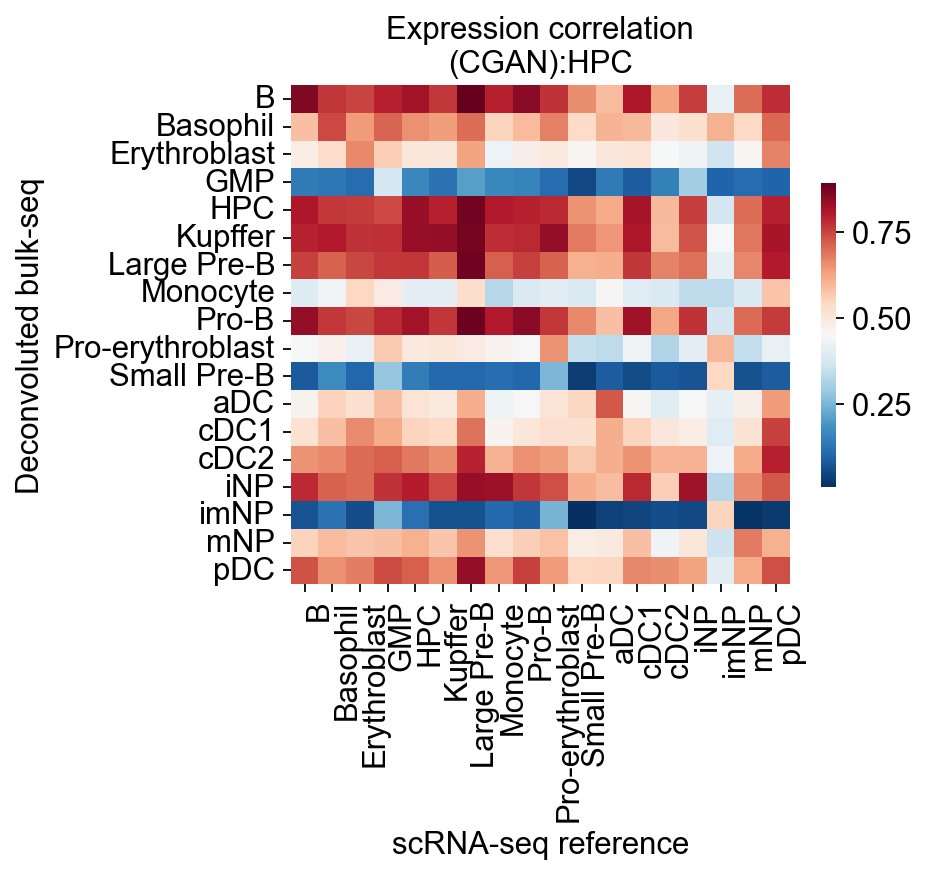

In [160]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cor_pd,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Expression correlation\n(CGAN):HPC")
plt.savefig('figures/heatmap_expcor_cgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_expcor_cgan_hpc.pdf',dpi=300,bbox_inches='tight')


In [106]:
cmk1=ov.single.get_celltype_marker(test_adata,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


In [107]:
adata_hpc1=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 18578/18648 genes are kept. Among 18578 genes, 17425 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Igha', 'Gm26917', 'Malat1', 'S100a8', 'S100a9', 'Igkc', 'Hbb-bs', 'Camp']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [108]:
cmk2=ov.single.get_celltype_marker(adata_hpc1,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)


In [118]:
cmk1={}
for clt in test_adata.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(test_adata, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk1[clt]=degs['names'][:100].tolist()

In [119]:
cmk2={}
for clt in adata_hpc1.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(adata_hpc1, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk2[clt]=degs['names'][:100].tolist()

In [120]:
all_gene=[]
for clt in cmk1.keys():
    all_gene+=cmk1[clt]
for clt in cmk2.keys():
    all_gene+=cmk2[clt]
all_gene=list(set(all_gene))

In [121]:
cmk1_pd=pd.DataFrame(index=all_gene)
for clt in cmk1.keys():
    cmk1_pd[clt]=0
    cmk1_pd.loc[cmk1[clt],clt]=1
cmk2_pd=pd.DataFrame(index=all_gene)
for clt in cmk2.keys():
    cmk2_pd[clt]=0
    cmk2_pd.loc[cmk2[clt],clt]=1

In [122]:
cmk1_pd['B'].sum()

100

In [123]:
cmk2_pd['B'].sum()

100

In [124]:
from scipy import spatial
plot_data=pd.DataFrame(index=test_adata.obs['celltype'].cat.categories,
                      columns=test_adata.obs['celltype'].cat.categories)
for clt1 in cmk1.keys():
    for clt2 in cmk1.keys():
    #print(clt,1 - spatial.distance.cosine(cmk1_pd['B'], cmk2_pd[clt]))
        plot_data.loc[clt1,clt2]=1 - spatial.distance.cosine(cmk1_pd[clt1], cmk2_pd[clt2])

In [125]:
plot_data=plot_data.astype(float)

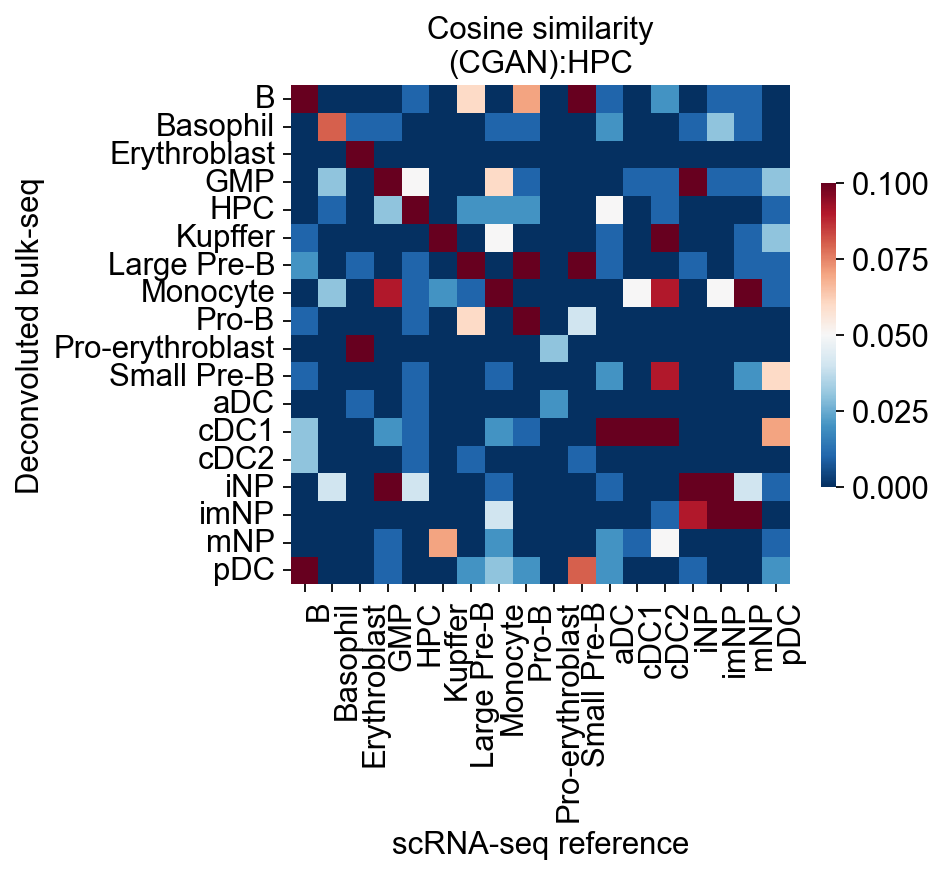

In [159]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(plot_data,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,vmax=0.1)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Cosine similarity\n(CGAN):HPC")
plt.savefig('figures/heatmap_cossim_cgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_cossim_cgan_hpc.pdf',dpi=300,bbox_inches='tight')


In [133]:
adata3=test_adata[test_adata.obs['celltype']=='Basophil']
adata3

View of AnnData object with n_obs × n_vars = 100 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'rank_genes_groups'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [134]:
import anndata
adata1=anndata.concat([bulktb.vae_model.single_data,adata3],
                     merge='same')
adata1

AnnData object with n_obs × n_vars = 5100 × 13849
    obs: 'celltype'
    obsm: 'scaled|original|X_pca', 'X_mde'

In [135]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [136]:
ov.pp.scale(adata1)
ov.pp.pca(adata1,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [137]:
adata1.obsm["X_mde"] = ov.utils.mde(adata1.obsm["scaled|original|X_pca"])
adata1

AnnData object with n_obs × n_vars = 5100 × 1578
    obs: 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

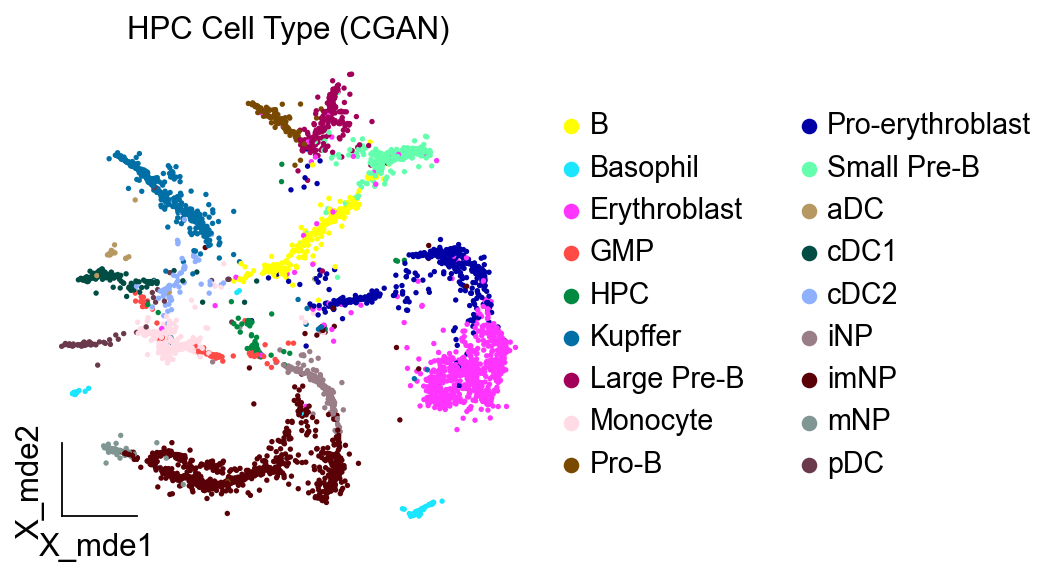

In [156]:
ov.utils.embedding(adata1,
                basis='X_mde',
           color=['celltype'],title='HPC Cell Type (CGAN)',
                   frameon='small',show=False,
           wspace=0.4,palette=sc.pl.palettes.default_102)
plt.savefig('figures/umap_hpc_cgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/umap_hpc_cgan.pdf',dpi=300,bbox_inches='tight')


In [94]:
adata2=bulktb.vae_model.single_data.copy()

In [95]:
adata2.raw = adata2
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata2 = adata2[:, adata2.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [96]:
ov.pp.scale(adata2)
ov.pp.pca(adata2,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [97]:
adata2.obsm["X_mde"] = ov.utils.mde(adata2.obsm["scaled|original|X_pca"])
adata2

AnnData object with n_obs × n_vars = 5000 × 3459
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'connectivities', 'distances'

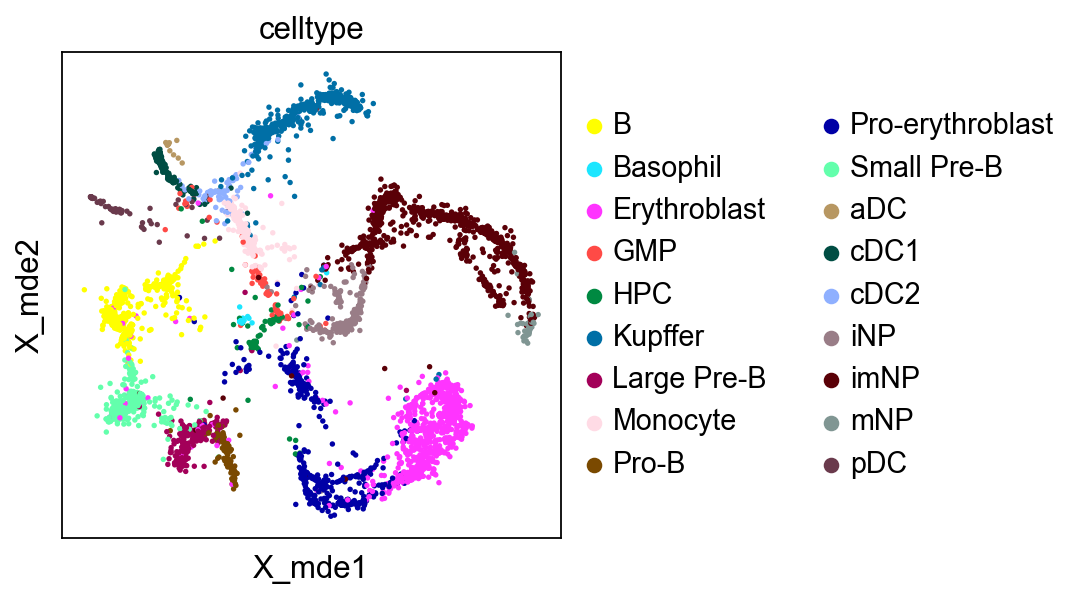

In [98]:
sc.pl.embedding(adata2,
                basis='X_mde',
           color=['celltype'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

In [127]:
v0 = ov.single.pyVIA(adata=adata2,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['HPC'],
                    dataset='group')
v0.run()

2023-10-03 21:24:09.667059	Running VIA over input data of 5000 (samples) x 50 (features)
2023-10-03 21:24:09.667088	Knngraph has 15 neighbors
2023-10-03 21:24:11.039529	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 49.0 % of edges. 
2023-10-03 21:24:11.053974	Number of connected components used for clustergraph  is 1
2023-10-03 21:24:11.121574	Commencing community detection
2023-10-03 21:24:11.354510	Finished running Leiden algorithm. Found 270 clusters.
2023-10-03 21:24:11.355604	Merging 227 very small clusters (<10)
2023-10-03 21:24:11.357655	Finished detecting communities. Found 43 communities
2023-10-03 21:24:11.357876	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-03 21:24:11.363211	Graph has 1 connected components before pruning
2023-10-03 21:24:11.364979	Graph has 2 connected components after pruning
2023-10-03 21:24:11.365724	Graph has 1 connected components after reconnecting
2023-10-03 21:24:11.366116	0.0% links tri

Text(0.5, 1.0, 'Raw HPC')

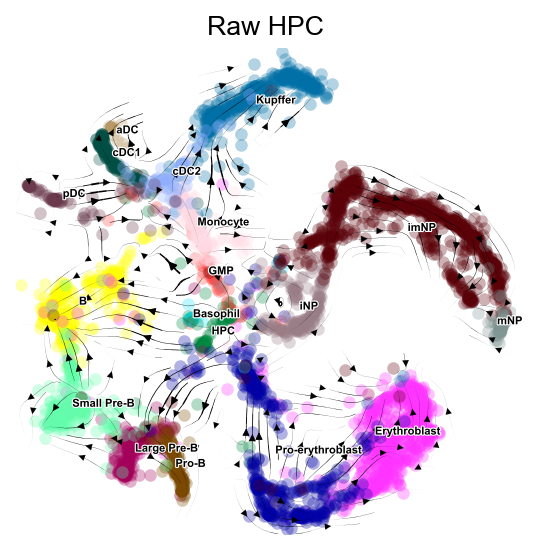

In [129]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Raw HPC',fontsize=12)

In [130]:
v0.get_pseudotime(adata2)
sc.pp.neighbors(adata2,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata2,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [131]:
raw_transitions=pd.DataFrame(adata2.uns['paga']['transitions_confidence'].toarray(),
            index=adata2.obs['celltype'].cat.categories,
            columns=adata2.obs['celltype'].cat.categories)

In [132]:
raw_transitions.loc['Basophil','HPC']

0.014009507308902016

In [139]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['HPC'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

2023-10-03 21:31:21.792067	Running VIA over input data of 5100 (samples) x 50 (features)
2023-10-03 21:31:21.792109	Knngraph has 15 neighbors
2023-10-03 21:31:23.203266	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 48.7 % of edges. 
2023-10-03 21:31:23.217561	Number of connected components used for clustergraph  is 2
2023-10-03 21:31:23.284821	Commencing community detection
2023-10-03 21:31:23.519506	Finished running Leiden algorithm. Found 259 clusters.
2023-10-03 21:31:23.520613	Merging 217 very small clusters (<10)
2023-10-03 21:31:23.522593	Finished detecting communities. Found 42 communities
2023-10-03 21:31:23.522852	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-03 21:31:23.528189	Graph has 2 connected components before pruning
2023-10-03 21:31:23.529922	Graph has 5 connected components after pruning
2023-10-03 21:31:23.531791	Graph has 2 connected components after reconnecting
2023-10-03 21:31:23.532196	0.0% links tri

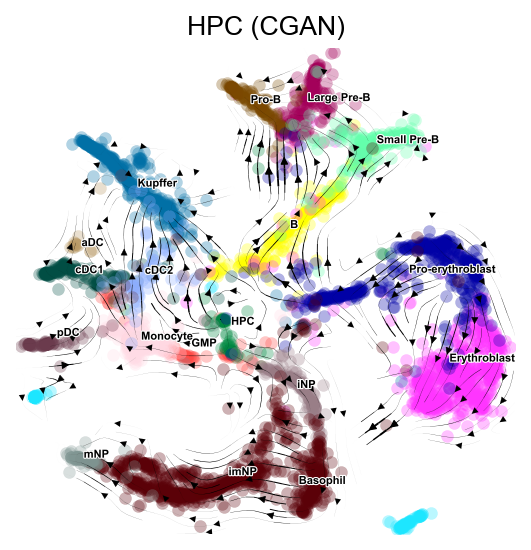

In [158]:
import matplotlib.pyplot as plt
fig,ax=v1.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('HPC (CGAN)',fontsize=12)
plt.savefig('figures/via_hpc_cgan.png',dpi=300,bbox_inches='tight')

<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

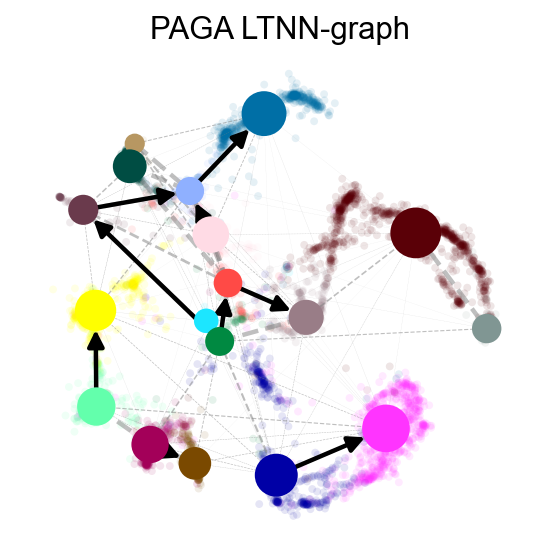

In [141]:
ov.utils.plot_paga(adata2,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

In [142]:
v1.get_pseudotime(adata1)
sc.pp.neighbors(adata1,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata1,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [143]:
after_transitions=pd.DataFrame(adata1.uns['paga']['transitions_confidence'].toarray(),
            index=adata1.obs['celltype'].cat.categories,
            columns=adata1.obs['celltype'].cat.categories)

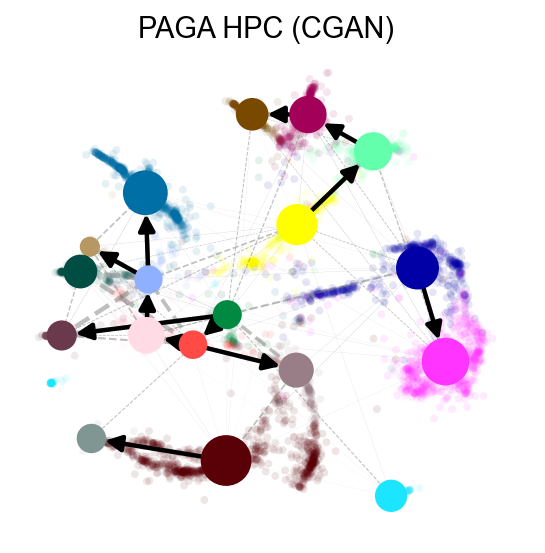

In [157]:
ov.utils.plot_paga(adata1,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA HPC (CGAN)',fontsize=13)
plt.savefig('figures/paga_hpc_cgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_hpc_cgan.pdf',dpi=300,bbox_inches='tight')

(0.0, 1.0)

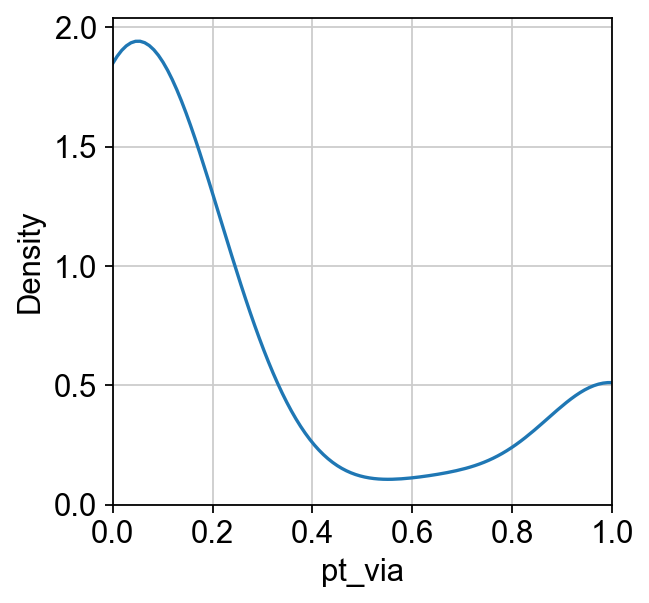

In [145]:
import seaborn as sns
sns.kdeplot(adata1.obs.loc[adata1.obs['celltype']=='Basophil'],x='pt_via')
plt.xlim(0,1)

In [146]:
np.var(adata1.obs.loc[adata1.obs['celltype']=='Basophil','pt_via'])

0.13749709430675155

(0.0, 1.0)

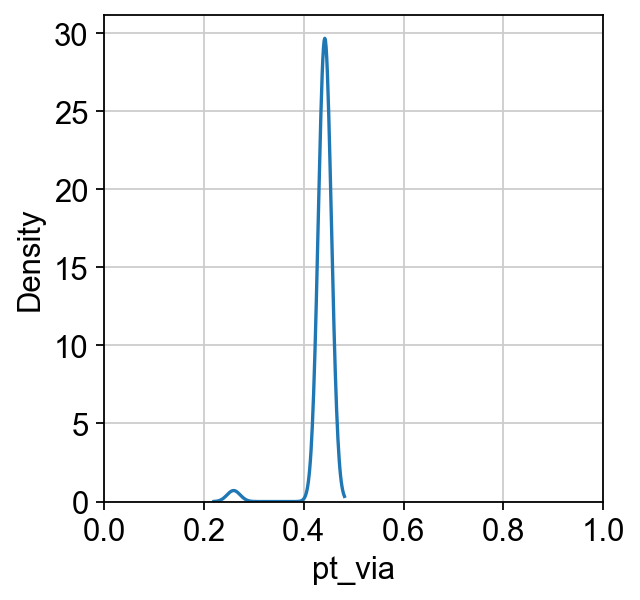

In [147]:
import seaborn as sns
sns.kdeplot(adata2.obs.loc[adata2.obs['celltype']=='Basophil'],x='pt_via')
plt.xlim(0,1)

In [148]:
np.var(adata2.obs.loc[adata2.obs['celltype']=='Basophil','pt_via'])

0.0007583192409709261

In [152]:
res_dict={}

#Cor:exp
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)
# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

res_dict['Cor_mean']=diagonal_mean
res_dict['non_Cor_mean']=non_diagonal_mean

#Cos:gene
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

res_dict['Cos_mean']=diagonal_mean
res_dict['non_Cos_mean']=non_diagonal_mean

#raw:trans
res_dict['Trans_raw']=raw_transitions.loc['Basophil'].max()
res_dict['Trans_after']=after_transitions.loc['Basophil'].max()


#Variance
res_dict['Var_raw']=np.var(adata2.obs.loc[adata2.obs['celltype']=='Basophil','pt_via'])
res_dict['Var_after']=np.var(adata1.obs.loc[adata1.obs['celltype']=='Basophil','pt_via'])


In [153]:
res_dict

{'Cor_mean': 0.6508122532867471,
 'non_Cor_mean': 0.5322544717844468,
 'Cos_mean': 0.1738888888888889,
 'non_Cos_mean': 0.015326797385620919,
 'Trans_raw': 0.014009507308902016,
 'Trans_after': 0.0,
 'Var_raw': 0.0007583192409709261,
 'Var_after': 0.13749709430675155}

In [154]:
import pickle
with open('result/metric_cgan_hpc.pkl','wb') as f:
    pickle.dump(res_dict,f)

In [155]:
with open('result/metric_cgan_hpc.pkl','rb') as f:
    res_dict=pickle.load(f)
res_dict

{'Cor_mean': 0.6508122532867471,
 'non_Cor_mean': 0.5322544717844468,
 'Cos_mean': 0.1738888888888889,
 'non_Cos_mean': 0.015326797385620919,
 'Trans_raw': 0.014009507308902016,
 'Trans_after': 0.0,
 'Var_raw': 0.0007583192409709261,
 'Var_after': 0.13749709430675155}